In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.preprocessing import image
import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import *
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import re
import nltk

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d hsankesara/flickr-image-dataset
! kaggle datasets download -d adityajn105/flickr8k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 1.02G/1.04G [00:05<00:00, 220MB/s]
100% 1.04G/1.04G [00:05<00:00, 198MB/s]


In [8]:
! mkdir Dataset
! unzip /content/flickr8k.zip 
! rm /content/flickr8k.zip
! mv /content/Images /content/Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

### Data Preprocessing

In [9]:
dataset = pd.read_csv('/content/captions.txt',delimiter=',',header=None)
dataset=dataset[1:]

In [10]:
print(dataset.shape)

(40455, 2)


In [11]:
dataset.head()

,0,1
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [12]:
print(dataset[0][3])
print(dataset[1][3])

1000268201_693b08cb0e.jpg
A little girl climbing into a wooden playhouse .


## Text pre-processing
Using regular expressing to get lower case and has been joint with start and end sequence tag.

In [13]:

corpus = []
for i in range(1, dataset.shape[0]):
    cap = re.sub('[^a-zA-Z]', ' ', dataset[1][i])  
    cap = cap.lower()                             
    cap = cap.split()                               
    cap=[word for word in cap if len(word)>1]     
    cap = ' '.join(cap)                            
    cap= '<startseq> '+cap+' <endseq>'
    corpus.append(cap)                            

In [14]:
for i in range(50): print(corpus[i:i+1])
print(len(corpus))

['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>']
['<startseq> girl going into wooden building <endseq>']
['<startseq> little girl climbing into wooden playhouse <endseq>']
['<startseq> little girl climbing the stairs to her playhouse <endseq>']
['<startseq> little girl in pink dress going into wooden cabin <endseq>']
['<startseq> black dog and spotted dog are fighting <endseq>']
['<startseq> black dog and tri colored dog playing with each other on the road <endseq>']
['<startseq> black dog and white dog with brown spots are staring at each other in the street <endseq>']
['<startseq> two dogs of different breeds looking at each other on the road <endseq>']
['<startseq> two dogs on pavement moving toward each other <endseq>']
['<startseq> little girl covered in paint sits in front of painted rainbow with her hands in bowl <endseq>']
['<startseq> little girl is sitting in front of large painted rainbow <endseq>']
['<startseq> small girl in the grass

In [15]:
i=1
while i < dataset.shape[0]:
  dataset[0][i]=dataset[0][i].split('.')[0]       
  i=i+1

In [16]:
print(dataset.head)

<bound method NDFrame.head of                               0  \
1         1000268201_693b08cb0e   
2         1000268201_693b08cb0e   
3         1000268201_693b08cb0e   
4         1000268201_693b08cb0e   
5         1000268201_693b08cb0e   
...                         ...   
40451      997722733_0cb5439472   
40452      997722733_0cb5439472   
40453      997722733_0cb5439472   
40454      997722733_0cb5439472   
40455  997722733_0cb5439472.jpg   

                                                       1  
1      A child in a pink dress is climbing up a set o...  
2                  A girl going into a wooden building .  
3       A little girl climbing into a wooden playhouse .  
4      A little girl climbing the stairs to her playh...  
5      A little girl in a pink dress going into a woo...  
...                                                  ...  
40451           A man in a pink shirt climbs a rock face  
40452           A man is rock climbing high in the air .  
40453  A person in

In [17]:
from collections import defaultdict
new_dict= defaultdict(lambda : [])     
i=1
while i <len(corpus):
  new_dict[dataset[0][i]].append(corpus[i-1])
  i=i+1                                                     

In [18]:
print(len(new_dict))

8091


In [19]:
all_vocab = []           

for key in new_dict.keys():
    [ all_vocab.append(i) for des in new_dict[key] for i in des.split()]

In [20]:
print("total words appearing : " , len(all_vocab))

total words appearing :  454697


Creating a word counter for the corpus

In [21]:
from collections import Counter

counter = Counter(all_vocab)

In [22]:
dic_ = dict(counter)

In [23]:
sorted_dic = sorted(dic_.items(), key = lambda x: x[1], reverse=True)  

In [24]:
print(len(sorted_dic))

8426


In [25]:
threshold_value = 10
d = [(x) for x in sorted_dic if x[1]>threshold_value]

In [26]:
len(d)

1847

In [27]:
all_vocab = [x[0] for x in d]                      

In [28]:
len(all_vocab)

1847

In [29]:
f = open('new_dict.txt', 'w')
f.write(str(new_dict))
f.close()

### Splitting train and test data

In [30]:
image_ids=[]
j=1
for i in range(0,len(dataset)//5 ):
    image_ids.append(dataset[0][j])
    j=j+5
    

In [31]:
new_dict[image_ids[0]]

['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>',
 '<startseq> girl going into wooden building <endseq>',
 '<startseq> little girl climbing into wooden playhouse <endseq>',
 '<startseq> little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> little girl in pink dress going into wooden cabin <endseq>']

In [32]:
split_train_to_test_ratio=0.8
train_end=int(split_train_to_test_ratio*len(image_ids))

train=image_ids[0:train_end]
test=image_ids[train_end:]

In [33]:
train_descriptions = {}               
for t in train:
    train_descriptions[t] = []
    for cap in new_dict[t]:
        train_descriptions[t].append(cap)

In [34]:
test_descriptions = {}             
for t in test:
    test_descriptions[t] = []
    for cap in new_dict[t]:
        test_descriptions[t].append(cap)

In [35]:
train_descriptions

{'1000268201_693b08cb0e': ['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>',
  '<startseq> girl going into wooden building <endseq>',
  '<startseq> little girl climbing into wooden playhouse <endseq>',
  '<startseq> little girl climbing the stairs to her playhouse <endseq>',
  '<startseq> little girl in pink dress going into wooden cabin <endseq>'],
 '1001773457_577c3a7d70': ['<startseq> black dog and spotted dog are fighting <endseq>',
  '<startseq> black dog and tri colored dog playing with each other on the road <endseq>',
  '<startseq> black dog and white dog with brown spots are staring at each other in the street <endseq>',
  '<startseq> two dogs of different breeds looking at each other on the road <endseq>',
  '<startseq> two dogs on pavement moving toward each other <endseq>'],
 '1002674143_1b742ab4b8': ['<startseq> little girl covered in paint sits in front of painted rainbow with her hands in bowl <endseq>',
  '<startseq> little girl is 

In [ ]:
# test_descriptions

### Importing and Loading the model

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import load_model

In [37]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))

102981632/102967424 [==============================] - 0s 0us/step


In [38]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [39]:
model_new = Model(inputs = model.input, outputs =  model.layers[-2].output)

#### Image Preprocessing
We take the train & test image datasets and preprocess them.

In [40]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img


In [41]:
def encode_image(img):
    img = preprocess_image(img)
    fea_vec = model_new.predict(img)
    fea_vec = fea_vec.reshape(fea_vec.shape[1], )
    return fea_vec

In [42]:
images='/content/Dataset/Images/'

In [43]:
start = time.time()
encoding_train = {}                                       
for ix, img in enumerate(train):    
    img = images+train[ix]+".jpg"
    p = encode_image(img)
    encoding_train[ img[len(images):] ] = p
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
print("Time taken in sec - " + str(time.time() - start))

Encoding image :0
Encoding image :100
Encoding image :200
Encoding image :300
Encoding image :400
Encoding image :500
Encoding image :600
Encoding image :700
Encoding image :800
Encoding image :900
Encoding image :1000
Encoding image :1100
Encoding image :1200
Encoding image :1300
Encoding image :1400
Encoding image :1500
Encoding image :1600
Encoding image :1700
Encoding image :1800
Encoding image :1900
Encoding image :2000
Encoding image :2100
Encoding image :2200
Encoding image :2300
Encoding image :2400
Encoding image :2500
Encoding image :2600
Encoding image :2700
Encoding image :2800
Encoding image :2900
Encoding image :3000
Encoding image :3100
Encoding image :3200
Encoding image :3300
Encoding image :3400
Encoding image :3500
Encoding image :3600
Encoding image :3700
Encoding image :3800
Encoding image :3900
Encoding image :4000
Encoding image :4100
Encoding image :4200
Encoding image :4300
Encoding image :4400
Encoding image :4500
Encoding image :4600
Encoding image :4700
Enco

In [47]:
len(encoding_train)

6472

In [48]:
encoding_train[train[0]+".jpg"]

array([0.06535949, 0.16782558, 0.32517588, ..., 0.05107145, 0.32821196,
       1.0043379 ], dtype=float32)

In [49]:
print("Time taken in sec - " + str(time.time() - start))

Time taken in sec - 488.5362195968628


In [50]:
start = time.time()
encoding_test = {}
for ix, img in enumerate(test):
    
    img = images+test[ix]+".jpg"
    
    p = encode_image(img)
    
    encoding_test[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + str(time.time() - start))

Encoding image :0
Encoding image :100
Encoding image :200
Encoding image :300
Encoding image :400
Encoding image :500
Encoding image :600
Encoding image :700
Encoding image :800
Encoding image :900
Encoding image :1000
Encoding image :1100
Encoding image :1200
Encoding image :1300
Encoding image :1400
Encoding image :1500
Encoding image :1600
Time taken in sec - 96.64089488983154


In [44]:
with open("./encoded_train_images.pkl", 'wb') as f:
    pickle.dump(encoding_train, f )

In [51]:
with open("./encoded_test_images.pkl", 'wb') as f:
    pickle.dump(encoding_test, f )

In [46]:
with open("./encoded_train_images.pkl", 'rb') as f:
    encoding_train = pickle.load(f)

In [52]:
with open("./encoded_test_images.pkl", 'rb') as f:
    encoding_test = pickle.load(f)

**Captions**

In [53]:
word_to_idx = {}
idx_to_word = {}
ix = 1
for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [56]:
len(all_vocab)

1847

In [58]:
vocab_size = len(idx_to_word) + 1
print(vocab_size)

1848


In [59]:
all_caption_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))

In [60]:
print(len(all_caption_len))
print(all_caption_len[:50])

32360
[16, 7, 8, 10, 11, 9, 15, 18, 14, 10, 18, 12, 19, 13, 11, 12, 14, 16, 11, 13, 10, 9, 11, 11, 14, 7, 8, 12, 12, 11, 15, 11, 9, 15, 11, 14, 14, 14, 14, 16, 11, 18, 8, 17, 21, 7, 9, 8, 14, 9]


In [61]:
max_len = max(all_caption_len)
print(max_len) 

35


### Generator Function
The Data Generator maps the Image encodings with the training captions for the training of the model

In [62]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len,  num_photos_per_batch ):
    X1, X2, y = [], [], []
    
    n=0
    cnt = 0
    all_items = list(train_descriptions.keys())
    
    while True:
      n+=1
      
      key = all_items[cnt]
      desc_list = train_descriptions[key]              
      cnt+=1
      cnt= (cnt%len(all_items))
        
      photo = encoding_train[key+".jpg"]
      for desc in desc_list:                     
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]                
                
        for i in range(1, len(seq)): 
            in_seq = seq[0:i]
            out_seq = seq[i]
            
            in_seq = pad_sequences( [in_seq], maxlen=max_len, value= 0, padding='post')[0]
        
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)

      if n == num_photos_per_batch:
          yield [np.array(X1), np.array(X2)] , np.array(y)
          X1, X2, y = [], [], []
          n = 0         

In [63]:
key="1000268201_693b08cb0e"
print(key)
print(encoding_train[key+".jpg"])

1000268201_693b08cb0e
[0.06535949 0.16782558 0.32517588 ... 0.05107145 0.32821196 1.0043379 ]


In [64]:
encoding_train

{'1000268201_693b08cb0e.jpg': array([0.06535949, 0.16782558, 0.32517588, ..., 0.05107145, 0.32821196,
        1.0043379 ], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.7841803 , 0.81896925, 0.06491401, ..., 0.08858448, 0.68538034,
        0.18749611], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([0.08411188, 0.61381125, 0.20675722, ..., 0.        , 3.0910556 ,
        1.5624405 ], dtype=float32),
 '1003163366_44323f5815.jpg': array([0.13873978, 0.13370955, 0.21037477, ..., 0.31287548, 0.43861902,
        0.58648455], dtype=float32),
 '1007129816_e794419615.jpg': array([0.07020082, 0.4670934 , 0.        , ..., 0.01412497, 0.        ,
        0.04985615], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.525798  , 0.37079573, 0.        , ..., 0.00266835, 0.29757273,
        0.11049554], dtype=float32),
 '1009434119_febe49276a.jpg': array([0.05470392, 0.01779996, 0.17593189, ..., 0.10565744, 0.2666014 ,
        0.22671713], dtype=float32),
 '1012212859_01547e3f17.jpg

In [65]:
for i in data_generator(train_descriptions, encoding_train, word_to_idx, max_len, 3):
    X, y = i
    print(X[0].shape) 
    print(X[1].shape)
    print(y.shape)
    break

(169, 2048)
(169, 35)
(169, 1848)


###  Word Embedding

In [66]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d hsankesara/flickr-image-dataset
! kaggle datasets download -d incorpes/glove6b200d

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 255M/259M [00:02<00:00, 94.7MB/s]
100% 259M/259M [00:02<00:00, 98.8MB/s]


In [67]:
! mkdir glove
! unzip /content/glove6b200d.zip 

Archive:  /content/glove6b200d.zip
  inflating: glove.6B.200d.txt       


In [68]:
embeddings = {}

with open("/content/glove.6B.200d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype="float32")
        embeddings[word] = coeffs


In [69]:
i=0
for keys,values in embeddings.items():
 i=i+1
 
 print(keys,values)
 
 if i>10:break

the [-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  9.5733e-02 -5.2860e-0

In [75]:
print(len(embeddings))

400000


In [71]:
def getOutputEmbeddings():
    emb_dim = 200
    embedding_matrix_output = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        emb_vec = embeddings.get(word)
        if emb_vec is not None:
            embedding_matrix_output[idx] = emb_vec
    return embedding_matrix_output

In [72]:
embedding_output = getOutputEmbeddings()

In [73]:
embedding_output.shape

(1848, 200)

In [74]:
print(embedding_output[5:7])

[[-0.39374     0.55684    -0.35848001 -0.67074001  0.073665    0.12643
  -0.013077   -0.25279999 -0.04863     0.087937   -0.20308     0.43673
   0.18453    -0.027372    0.18987     0.23822001 -0.092781    0.31736001
   0.15368     0.14471     0.37138     3.15409994  0.13773     0.0037497
   0.14195     0.40222001 -0.56691003  0.17663001 -0.37059999  0.19401
   0.074044   -0.19639     0.093499    0.78948998  0.10651    -0.54262
  -0.82392001 -0.59018999 -0.0074686   0.048896    0.26594999 -0.071857
   0.28968     0.46733001  0.17434999  0.65547001  0.069246   -0.78889
   0.20286     0.44911    -0.54470998  0.10789     0.040975    0.60115999
  -0.14781    -0.21917     0.16495     0.40391001  0.33915001  0.36809999
   0.034313   -0.19927999 -0.40278    -0.15649     0.010548   -0.27677
   0.066898   -0.16745999  0.1288     -0.11875     0.13574    -0.13967
  -0.1601      0.20059     0.042929    0.34299999  0.027023   -0.26837999
   0.096476    0.05495    -0.20767    -0.52867001 -0.32010999 

### Model Architecture
Development and stacking of the model's layers

In [76]:
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [77]:
print(inp_img2.shape)

(None, 256)


In [78]:
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim= vocab_size, output_dim=200, mask_zero=True)(input_cap)

inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [79]:
print(inp_cap3.shape)

(None, 256)


In [80]:
decoder1 = add([inp_img2, inp_cap3])
print(decoder1.shape)
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs = [input_img_fea, input_cap]  , outputs =  output )

(None, 256)


In [81]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      369600      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [82]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

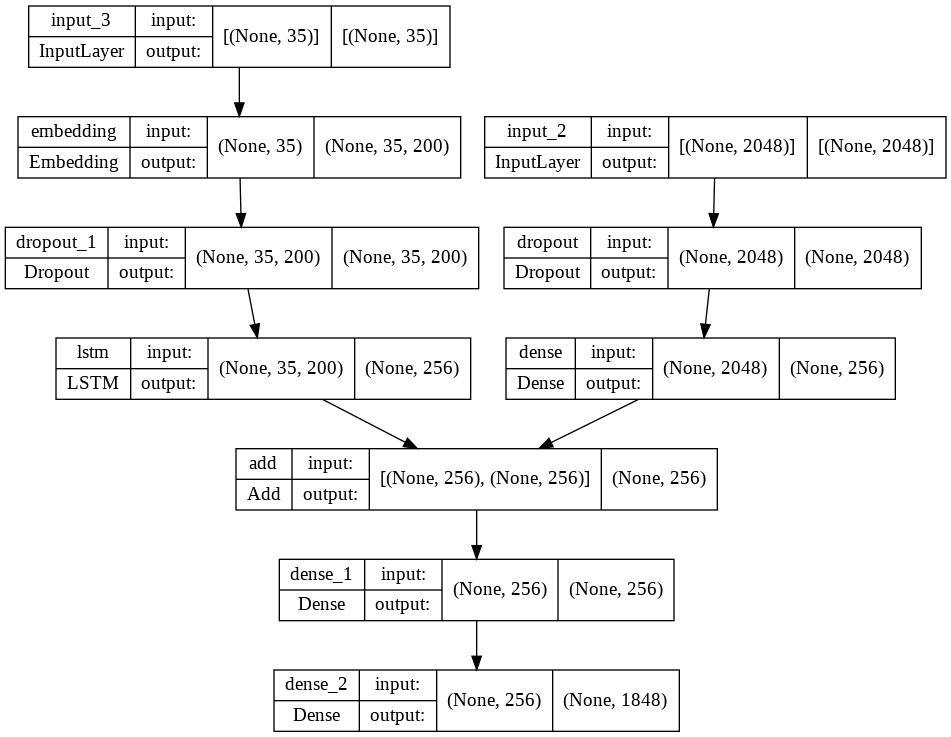

In [83]:
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [84]:
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy']) 

### Model Training

In [85]:
epochs = 20
number_photos_per_batch = 3
steps = len(train_descriptions)//number_photos_per_batch

mytraingen = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_photos_per_batch)

model.fit(mytraingen,steps_per_epoch=steps,epochs = epochs)
model.save(filepath="./best_model1.h5")

Epoch 1/20
2157/2157 [==============================] - 37s 15ms/step - loss: 4.0841 - accuracy: 0.2497
Epoch 2/20
2157/2157 [==============================] - 33s 15ms/step - loss: 3.3539 - accuracy: 0.3048
Epoch 3/20
2157/2157 [==============================] - 33s 15ms/step - loss: 3.1202 - accuracy: 0.3238
Epoch 4/20
2157/2157 [==============================] - 33s 15ms/step - loss: 2.9723 - accuracy: 0.3369
Epoch 5/20
2157/2157 [==============================] - 34s 16ms/step - loss: 2.8641 - accuracy: 0.3472
Epoch 6/20
2157/2157 [==============================] - 32s 15ms/step - loss: 2.7823 - accuracy: 0.3560
Epoch 7/20
2157/2157 [==============================] - 33s 16ms/step - loss: 2.7137 - accuracy: 0.3633
Epoch 8/20
2157/2157 [==============================] - 32s 15ms/step - loss: 2.6619 - accuracy: 0.3688
Epoch 9/20
2157/2157 [==============================] - 32s 15ms/step - loss: 2.6150 - accuracy: 0.3742
Epoch 10/20
2157/2157 [==============================] - 32s 15m

In [86]:
model.save_weights("./weights1.h5") 

### Predictor Function
This function takes an image and predicts the corresponding caption for it by pasiing it into the model

In [87]:
def predict(photo_enc,model):
    in_text = "<startseq>"
    
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        y_pred = model.predict([photo_enc, sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word[y_pred]
        in_text += " "+word  
        if word == '<endseq>':
            break
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

In [88]:
model=load_model("/content/best_model1.h5")

In [89]:
len(encoding_test)

1619

3601569729_bf4bf82768.jpg
two rodeo are in rugby match


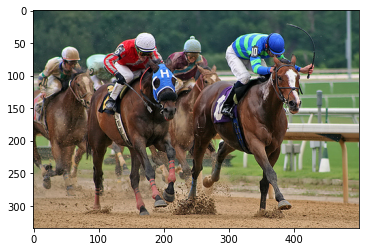

3601803640_5f3cb05acf.jpg
man in red shirt is standing next to woman in white shirt and sunglasses


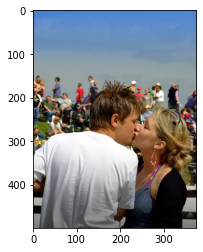

3601843201_4809e66909.jpg
motorcycle racer is in the air


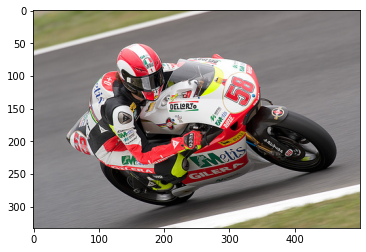

3601978895_9fec23ce0c.jpg
man is performing trick on bicycle in mostly barren ground


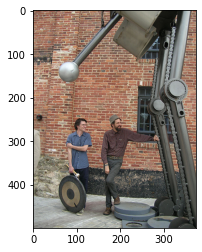

3602676311_824b2c04ba.jpg
man in yellow and white uniform is performing trick on ramp


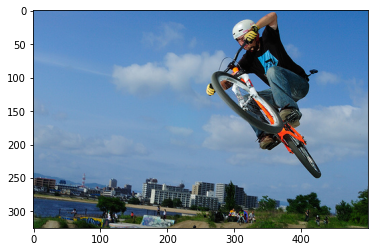

3602838407_bf13e49243.jpg
two dogs are running through the water


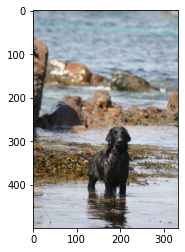

3603064161_a8f3b6455d.jpg
man in black shirt is sitting on the ground with beer


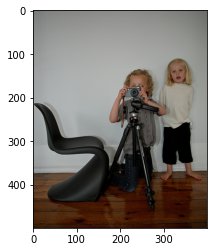

3603116579_4a28a932e2.jpg
baseball player in white and white uniform is throwing baseball bat


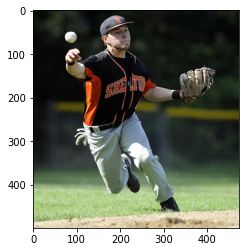

3603301825_5817727be2.jpg
two men in white and black uniforms are playing soccer


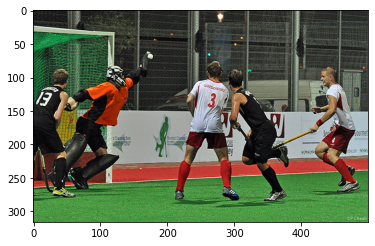

3603870481_1ebc696d91.jpg
black dog is running through the water


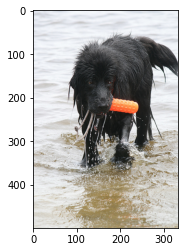

In [96]:
scores=[]
for rn in range(10):
    img_id = list(encoding_test.keys())[rn]
    photo_enc = encoding_test[img_id].reshape((1,2048))
    print(img_id)

    pred = predict(photo_enc,model)

    print(pred)
    path = images + img_id
    img = plt.imread(path)
    plt.imshow(img)
    plt.show()